In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
data = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_33760\3596567331.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../PrometneNesreče.csv")


# Kosinor analiza po urah: delovnik vs. vikend

In [3]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

# Dodaj stolpca za uro in dan v tednu
data['hour'] = data['NastanekDatumCas'].dt.hour
data['weekday'] = data['NastanekDatumCas'].dt.weekday

# Razdeli dneve na delovnik in vikend
workdays = data[data['weekday'] < 5]
weekends = data[data['weekday'] >= 5]

# Preštej nesreče po urah za delovnik
accidents_per_hour_workdays = workdays['hour'].value_counts().sort_index()

# Preštej nesreče po urah za vikend
accidents_per_hour_weekend = weekends['hour'].value_counts().sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_workdays = pd.DataFrame({
    "test": "HourlyAccidents_Workdays",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour_workdays.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour_workdays.values  # Število nesreč za tisto uro
})

df_weekends = pd.DataFrame({
    "test": "HourlyAccidents_Weekends",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour_weekend.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour_weekend.values  # Število nesreč za tisto uro
})


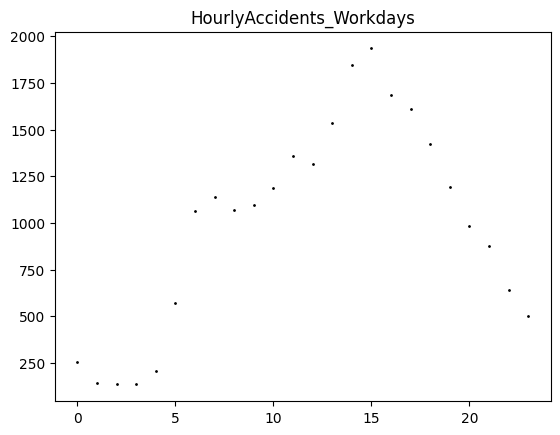

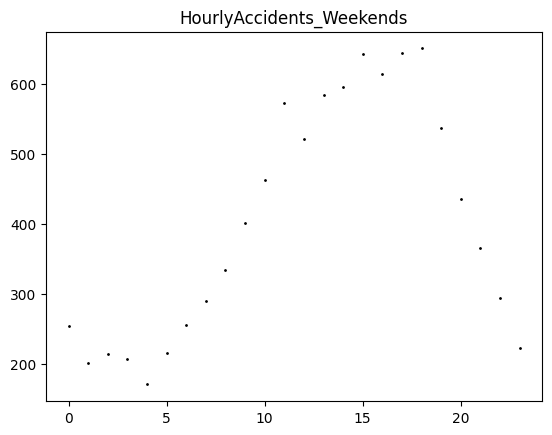

In [4]:
cosinor.plot_data(df_workdays, names = ["HourlyAccidents_Workdays"])
cosinor.plot_data(df_weekends, names = ["HourlyAccidents_Weekends"])

~~Periodogram~~

In [5]:
# cosinor.periodogram_df(df_workdays)
# cosinor.periodogram_df(df_weekends)

## CosinorPy

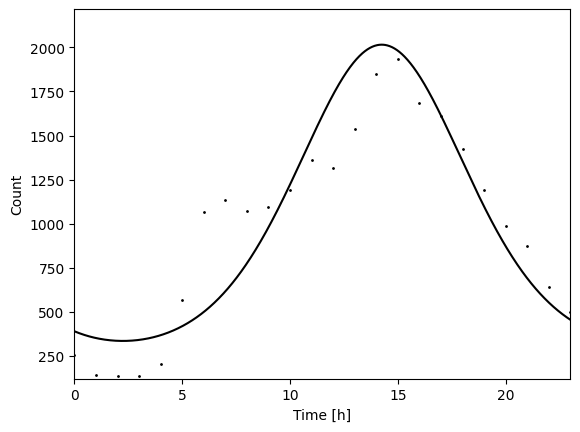

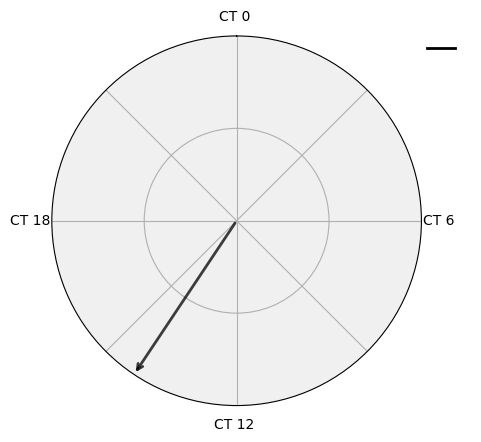

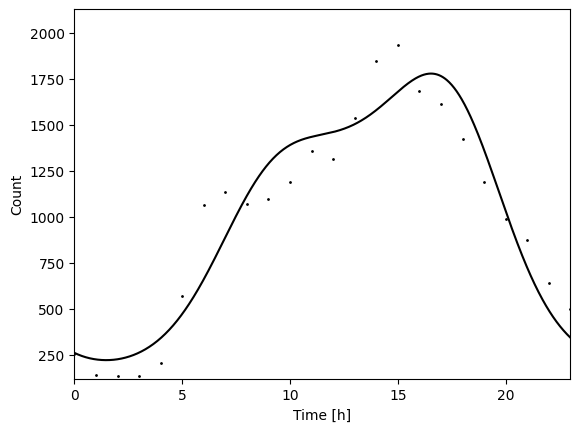

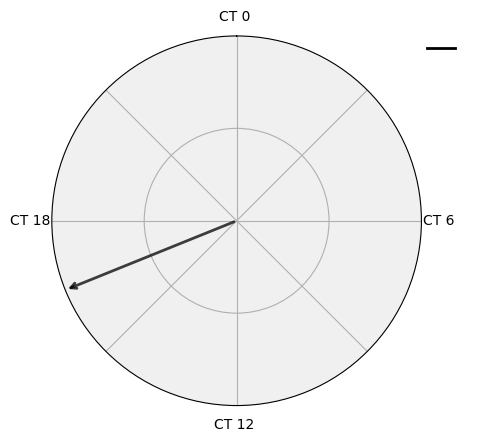

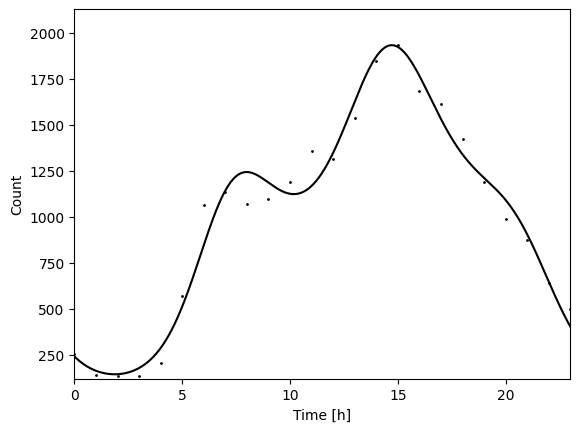

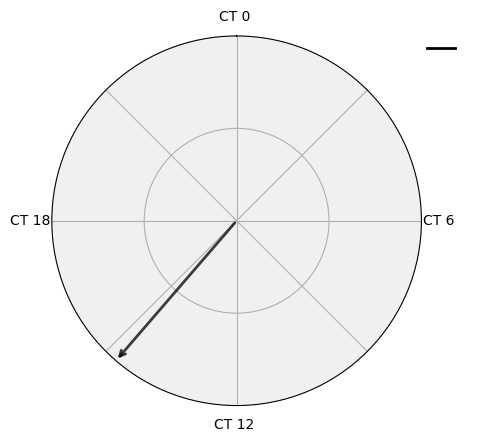

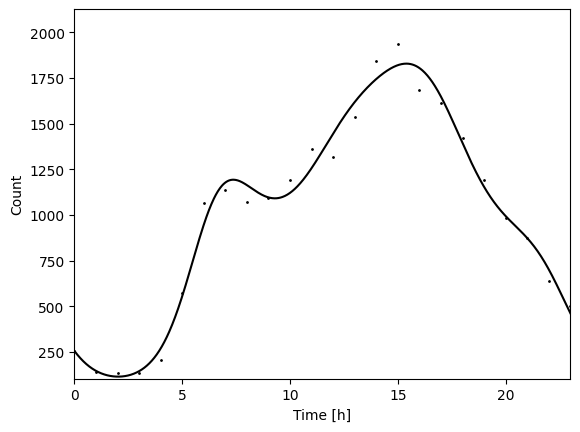

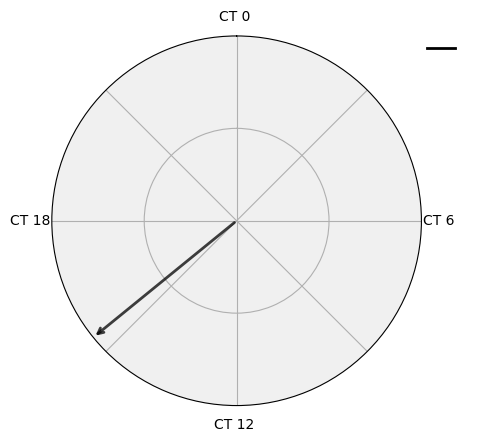

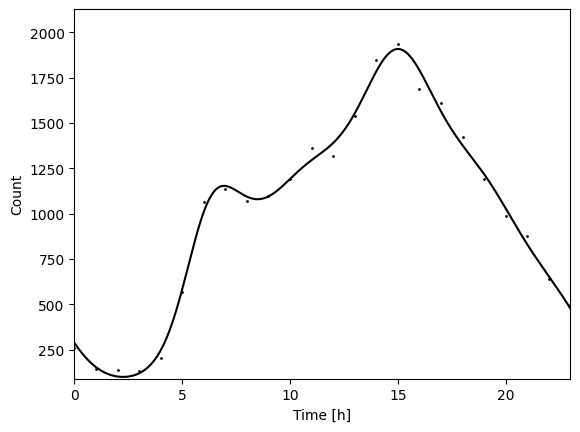

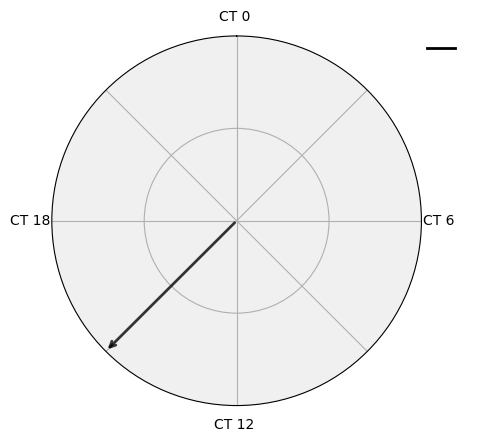

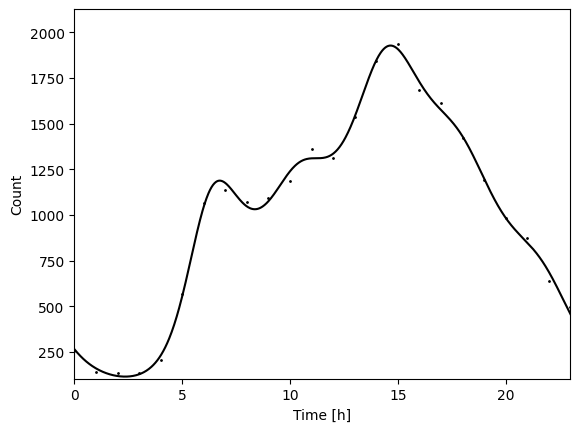

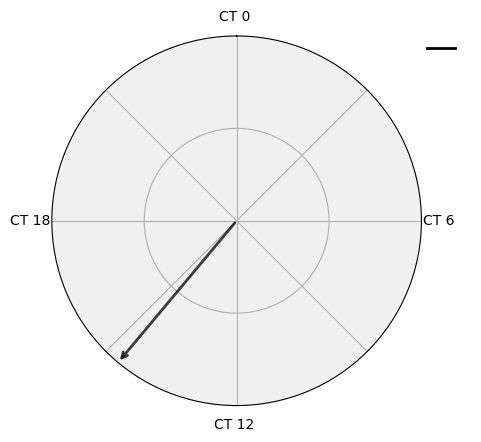

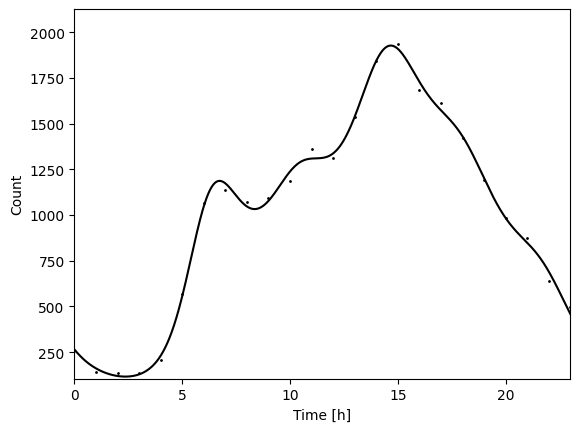

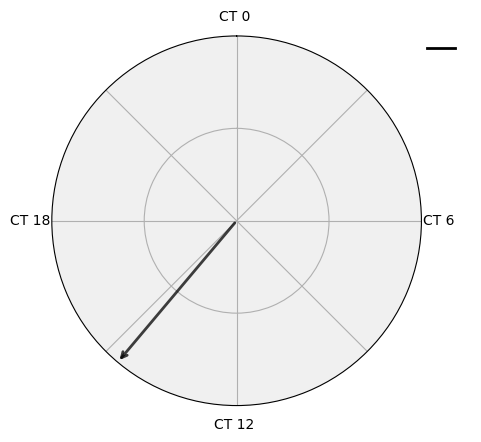

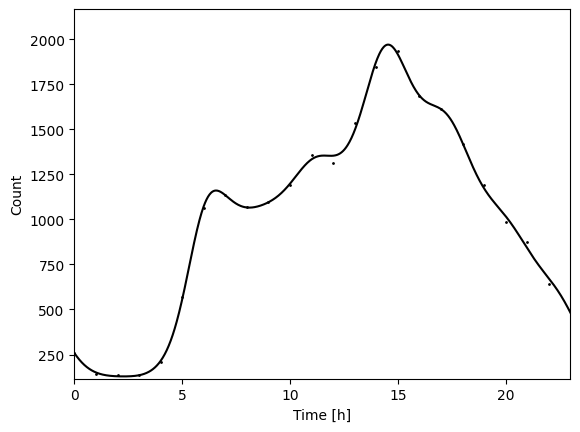

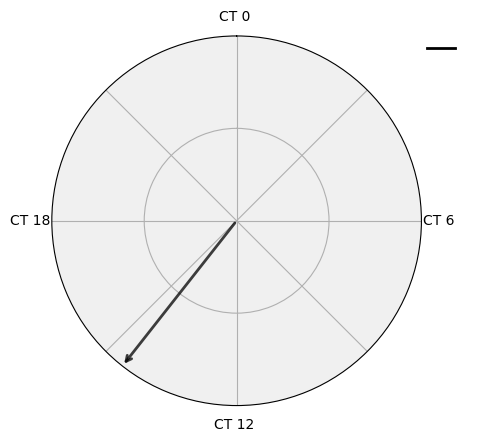

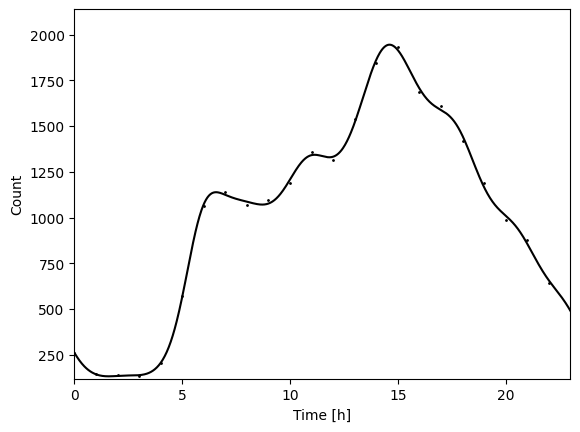

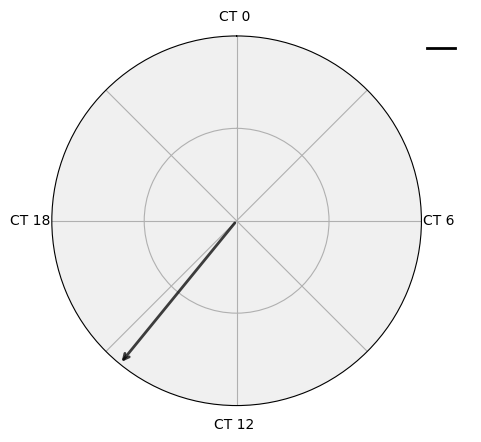

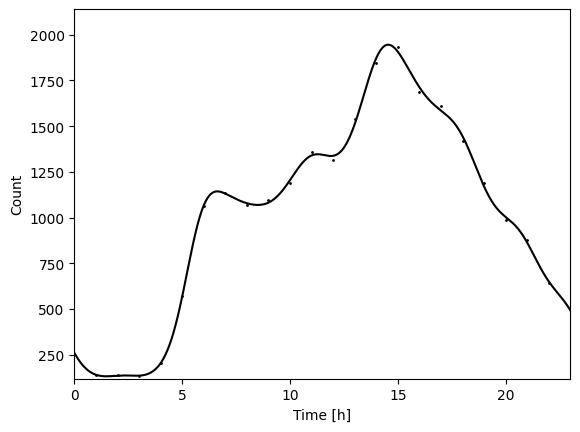

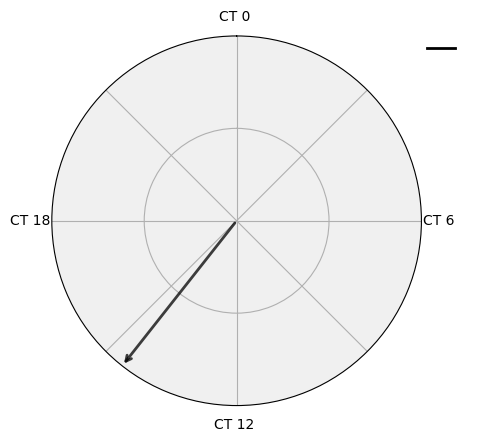

In [12]:
# DELOVNIK
X = df_workdays.x.to_numpy()
Y = df_workdays.y.to_numpy()

df_results_work = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results_work = df_add_row(df_results_work, {
        'test': 'HourlyAccidents_Workdays', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        # 'AIC': results.aic,
        # 'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_workdays)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidents_Workdays', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results_work.q = multi.multipletests(df_results_work.p, method = 'fdr_bh')[1]


# Dataframe za najboljši model
df_best_model_workdays = pd.DataFrame([{
        'test': 'HourlyAccidents_Workdays',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        # 'AIC': results_simpler.aic,
        # 'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [6]:
df_results_work

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents_Workdays,24.0,1.0,3.448374e-11,3.448374e-11,1.344984e+06,-165.873473,0.126816,839.605252,2.553114,1175.307307,[14.247824782478249],[2014.9124583005296],[2.2514251425142517],[335.7020973619819]
1,HourlyAccidents_Workdays,24.0,2.0,7.350826e-14,8.167584e-14,7.011761e+05,-156.173277,0.177880,777.610717,1.954894,1000.012357,[16.532853285328535],[1777.622829006917],[1.4737473747374739],[222.40164017124837]
2,HourlyAccidents_Workdays,24.0,3.0,2.508815e-19,3.136018e-19,1.903993e+05,-139.963803,0.263209,893.000957,2.429951,1038.601117,"[7.987998799879989, 14.71827182718272]","[1243.3571763375733, 1931.6017415502874]",[1.8673867386738676],[145.60015957259705]
3,HourlyAccidents_Workdays,24.0,4.0,1.520853e-21,2.172647e-21,1.143689e+05,-131.567167,0.307410,857.155357,2.254004,971.683401,"[7.36873687368737, 15.390339033903391]","[1193.1179893575309, 1828.83865117102]",[2.025802580258026],[114.52817189693312]
4,HourlyAccidents_Workdays,24.0,5.0,9.198517e-24,1.533086e-23,4.334018e+04,-123.235711,0.351268,903.889183,2.354545,1003.846097,"[6.936693669366937, 15.006300630063008]","[1153.2214155777701, 1907.7352798570175]",[2.2610261026102614],[99.95702524454565]
5,HourlyAccidents_Workdays,24.0,6.0,3.774782e-26,9.436955e-26,1.847529e+04,-114.528645,0.397103,906.109461,2.445032,1021.908457,"[6.739873987398741, 14.660666066606662]","[1188.590522295739, 1928.0175917814859]",[2.3522352235223525],[115.79899589289178]
6,HourlyAccidents_Workdays,24.0,7.0,4.745983e-25,9.491965e-25,1.866876e+04,-114.513403,0.397184,905.937230,2.442518,1022.089755,"[6.730273027302731, 14.670267026702671]","[1187.390823703617, 1928.0268929913636]",[2.361836183618362],[116.15261893945944]
7,HourlyAccidents_Workdays,24.0,8.0,2.315827e-28,7.719425e-28,9.872629e+03,-103.559901,0.454845,921.284873,2.475194,1049.704902,"[6.571857185718573, 11.56915691569157, 14.5454...","[1160.724541816562, 1354.7870022971947, 1970.9...",[2.285028502850285],[128.42002890668343]
8,HourlyAccidents_Workdays,24.0,9.0,2.308039e-30,2.308039e-29,6.333789e+03,-95.886702,0.495238,906.884793,2.457600,1038.412636,"[6.567056705670567, 11.137113711371137, 14.612...","[1138.4595799110532, 1343.1635627682297, 1945....",[1.5841584158415842],[131.52789279543904]
9,HourlyAccidents_Workdays,24.0,10.0,6.474067e-30,3.237034e-29,6.635791e+03,-94.422250,0.502947,906.429487,2.473937,1039.051765,"[6.62946294629463, 11.276327632763277, 14.5502...","[1143.6618275845435, 1346.6903178104246, 1945....","[1.4785478547854787, 2.8658865886588663]","[132.62235470570536, 135.72624322759592]"


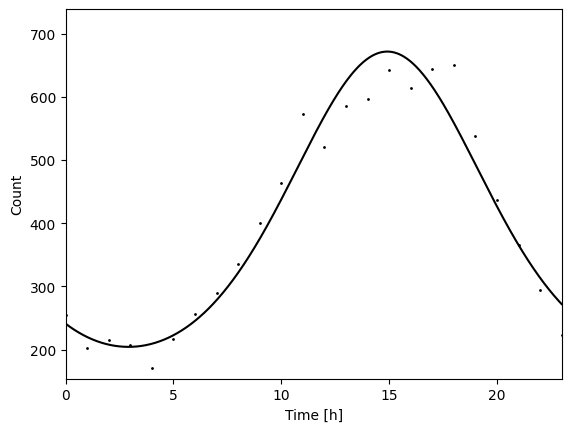

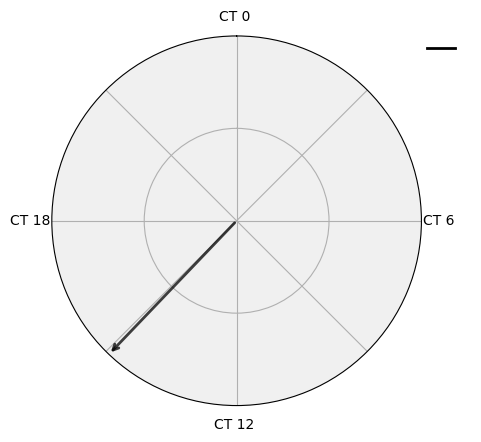

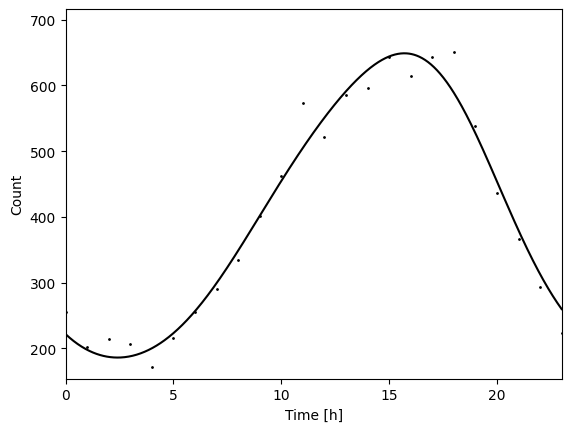

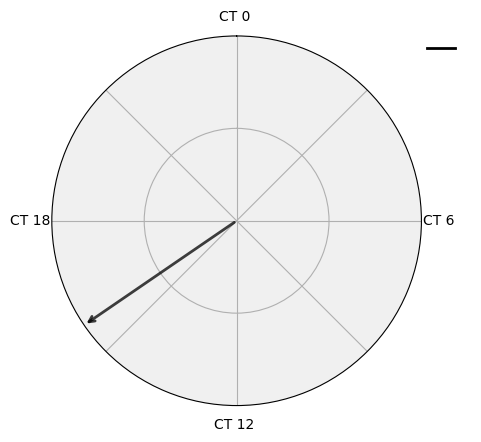

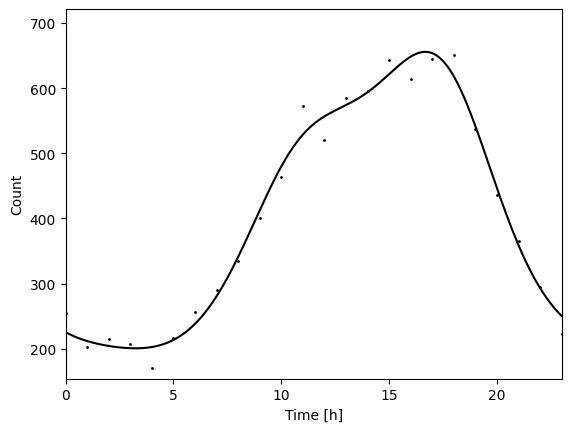

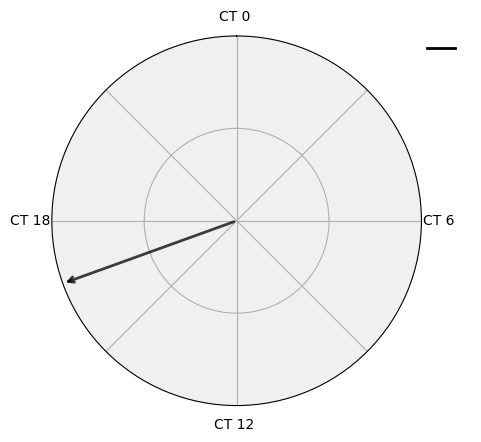

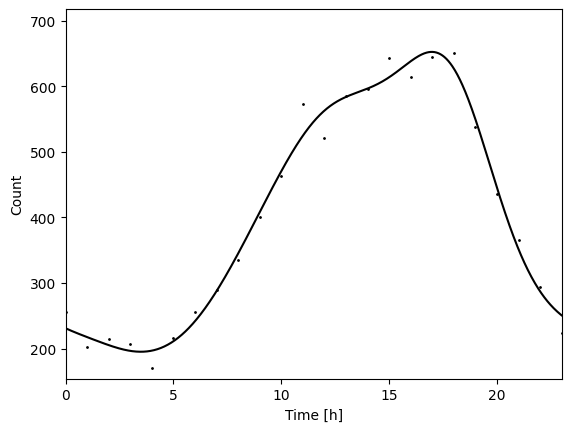

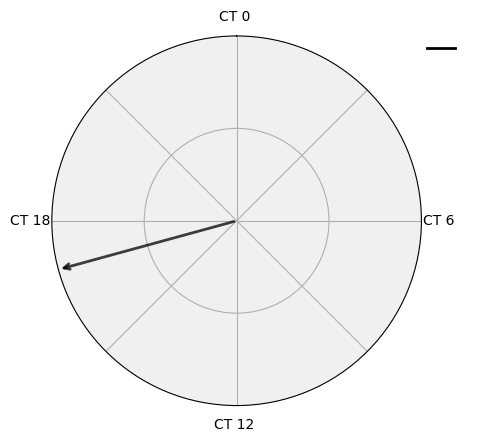

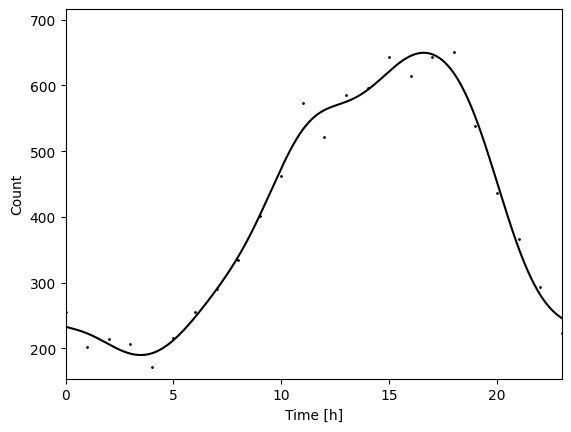

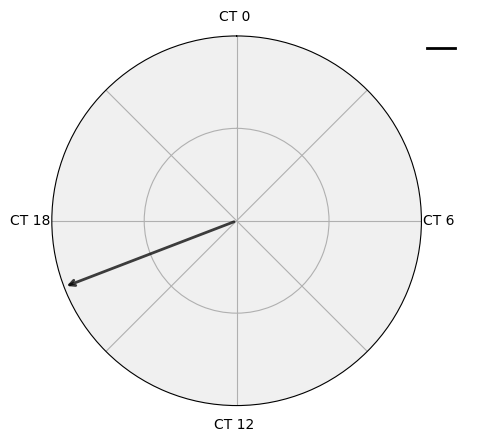

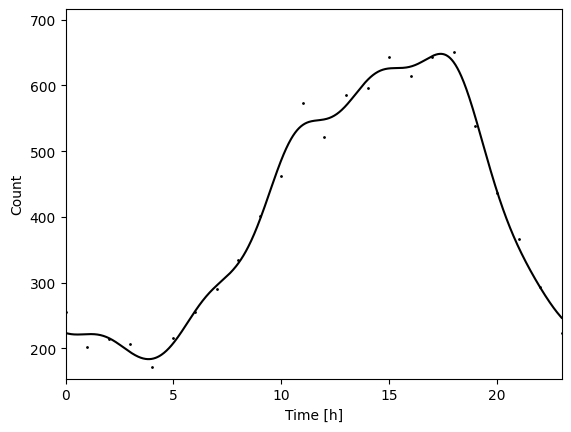

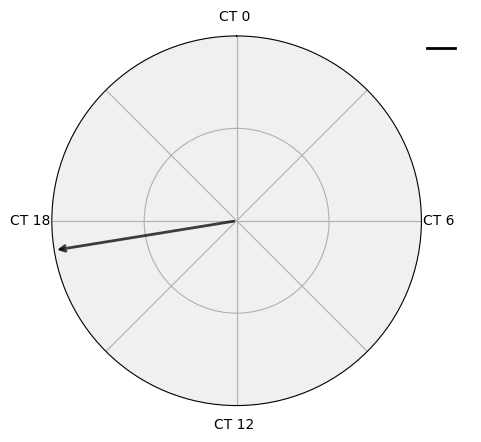

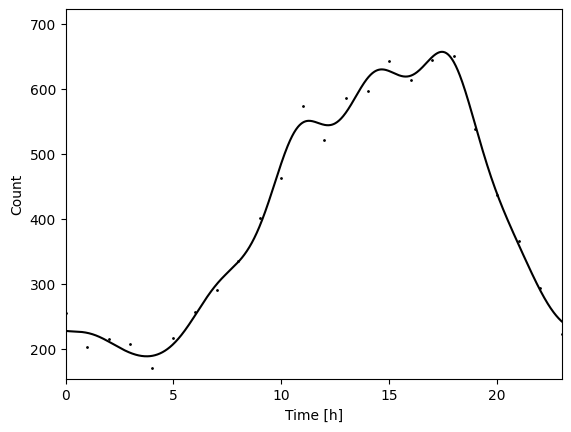

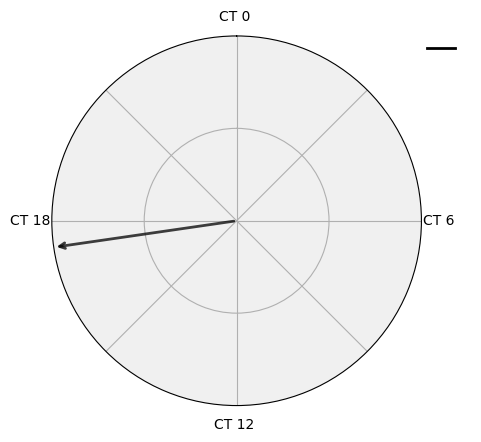

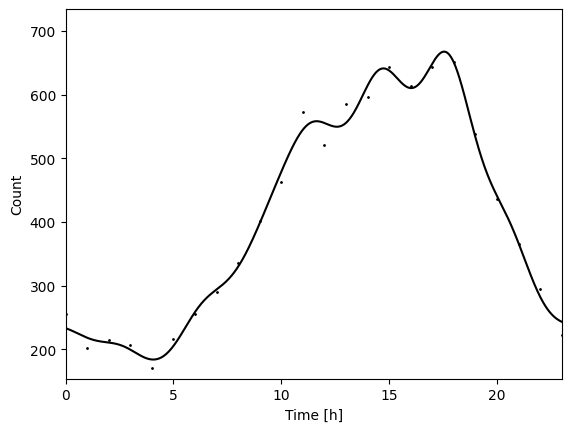

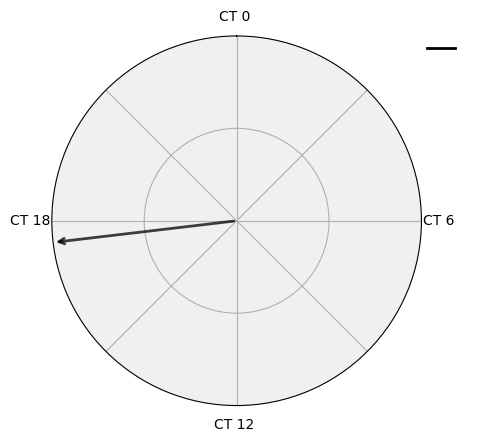

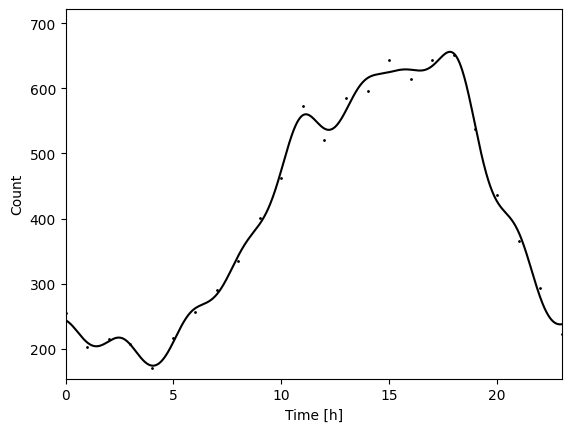

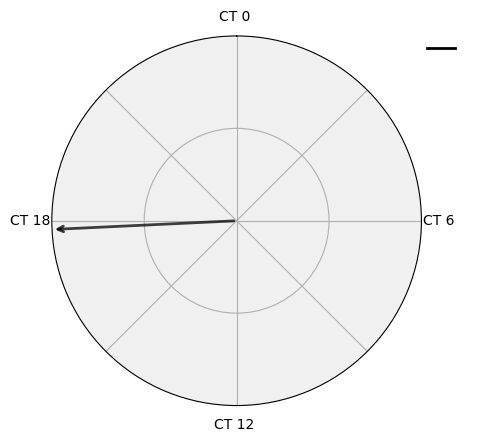

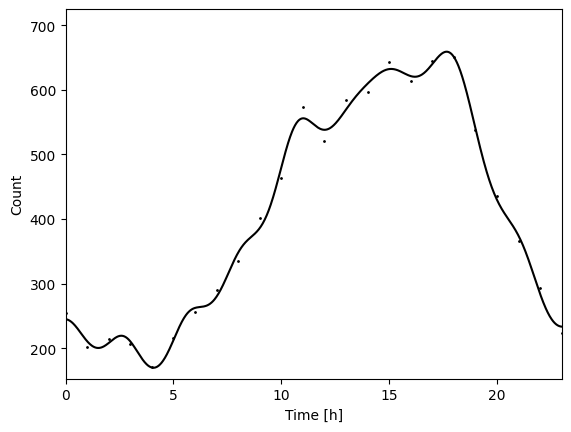

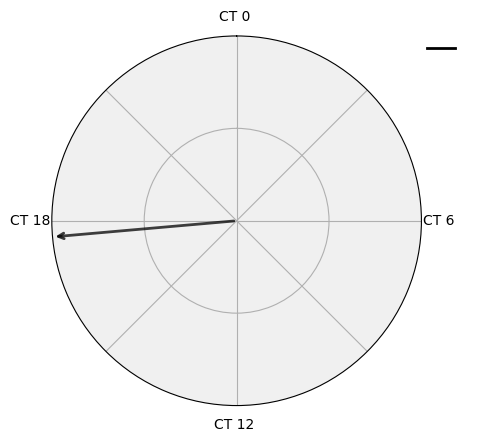

In [13]:
# VIKEND
X = df_weekends.x.to_numpy()
Y = df_weekends.y.to_numpy()

df_results_weekends = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results_weekends = df_add_row(df_results_weekends, {
        'test': 'HourlyAccidents_Weekends', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        # 'AIC': results.aic,
        # 'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_weekends)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidents_Weekends', n_component, results, statistics, rhythm_param, model, p_accept_llf])


df_results_weekends.q = multi.multipletests(df_results_weekends.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model
df_best_model_weekends = pd.DataFrame([{
        'test': 'HourlyAccidents_Weekends',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        # 'AIC': results_simpler.aic,
        # 'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [14]:
df_results_weekends

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents_Weekends,24.0,1.0,3.034024e-17,3.470548e-17,33240.957638,-118.046324,0.243682,233.659296,2.378423,437.972454,[14.915091509150916],[671.6317507942723],[2.913891389138914],[204.31315800637555]
1,HourlyAccidents_Weekends,24.0,2.0,4.542750e-18,9.085500e-18,17362.788395,-112.346654,0.280200,231.408321,2.171058,417.500694,[15.707170717071708],[648.9090151729649],[2.40984098409841],[186.09237367508516]
2,HourlyAccidents_Weekends,24.0,3.0,3.250335e-19,2.553252e-18,10089.574168,-106.349720,0.318622,227.580184,1.917192,428.161841,[16.676867686768677],[655.7419936789455],[3.235523552355236],[200.58165777006923]
3,HourlyAccidents_Weekends,24.0,4.0,2.135498e-18,5.338746e-18,9547.016315,-105.344733,0.325061,228.740381,1.838016,423.800368,[16.97929792979298],[652.5407494268068],[3.4851485148514856],[195.059987234147]
4,HourlyAccidents_Weekends,24.0,5.0,1.293985e-17,1.848550e-17,9167.763001,-104.522314,0.330330,229.886469,1.937300,419.833734,[16.6000600060006],[649.7201621463834],[3.4803480348034808],[189.9472643254586]
5,HourlyAccidents_Weekends,24.0,6.0,8.509112e-18,1.418185e-17,6324.927475,-101.467012,0.349905,232.202427,1.731191,415.883306,[17.38733873387339],[648.0857322889849],"[0.5472547254725473, 3.8451845184518456]","[221.1292363725634, 183.68093374572024]"
6,HourlyAccidents_Weekends,24.0,7.0,3.123493e-17,3.470548e-17,5515.210484,-100.428154,0.356561,234.183200,1.714853,422.552857,"[11.281128112811283, 14.660666066606662, 17.44...","[550.6259610294865, 629.7030386151873, 656.735...",[3.753975397539754],[188.36965757336523]
7,HourlyAccidents_Weekends,24.0,8.0,3.983301e-17,3.983301e-17,5216.799493,-98.323402,0.370046,241.716096,1.688461,425.716925,"[11.636363636363637, 14.73747374737474, 17.550...","[558.2086370012324, 641.1135891317416, 667.433...",[4.061206120612061],[184.0008287429253]
8,HourlyAccidents_Weekends,24.0,9.0,5.328985e-19,2.553252e-18,3182.846835,-91.085591,0.416419,241.126941,1.618082,415.045676,"[11.141914191419144, 15.76957695769577, 17.819...","[560.2115562941334, 629.1969315836615, 656.172...","[1.425742574257426, 4.046804680468047, 22.9318...","[203.74690640861022, 173.9188165701926, 237.41..."
9,HourlyAccidents_Weekends,24.0,10.0,7.659757e-19,2.553252e-18,2583.743723,-89.201125,0.428492,244.568445,1.658298,414.486182,"[11.017101710171017, 15.092709270927093, 17.66...","[555.9867615573824, 632.3868040081395, 659.054...","[1.5121512151215122, 4.075607560756076, 23.027...","[200.5119952270305, 169.91773690712392, 233.50..."


## Najboljša modela

In [15]:
# df_best_model_workdays = cosinor.get_best_models(df_workdays, df_results_work, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model_workdays

,test,period,n_components,p,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents_Workdays,24,3,2.508815e-19,190399.316533,-139.963803,0.263209,893.000957,2.429951,1038.601117,"[7.987998799879989, 14.71827182718272]","[1243.3571763375733, 1931.6017415502874]",[1.8673867386738676],[145.60015957259705]


In [16]:
# df_best_model_weekends = cosinor.get_best_models(df_weekends, df_results_weekends, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model_weekends

,test,period,n_components,p,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents_Weekends,24,1,3.034024e-17,33240.957638,-118.046324,0.243682,233.659296,2.378423,437.972454,[14.915091509150916],[671.6317507942723],[2.913891389138914],[204.31315800637555]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


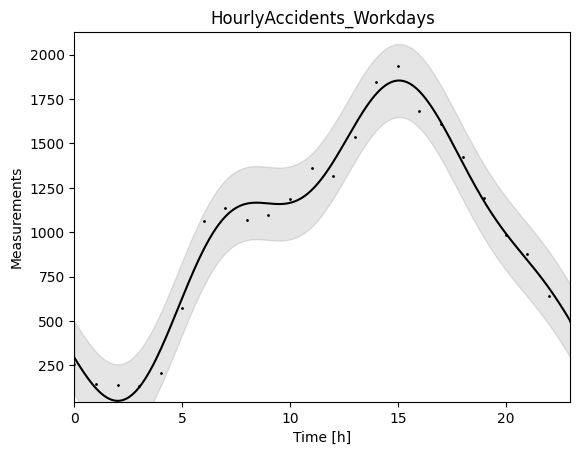

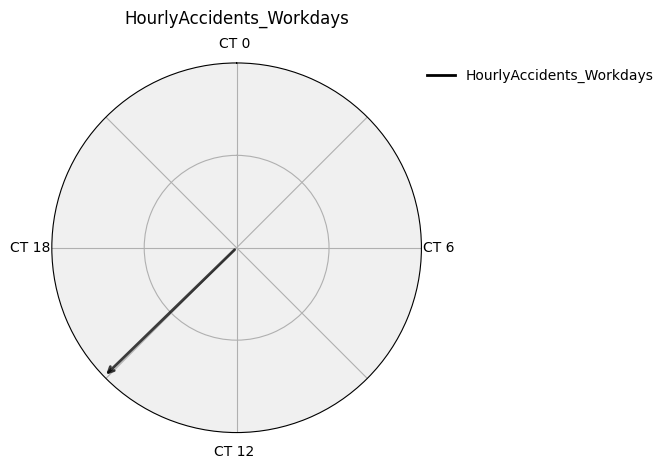

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


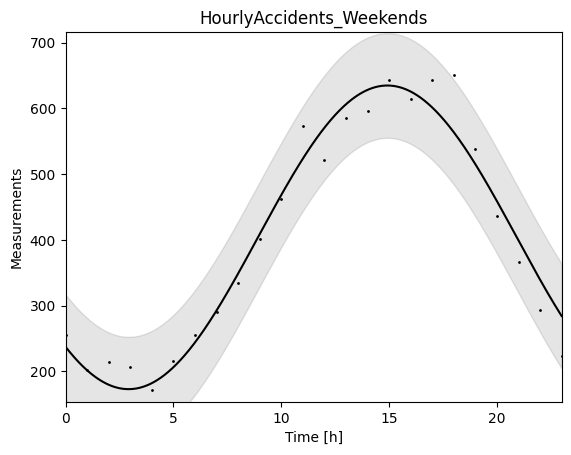

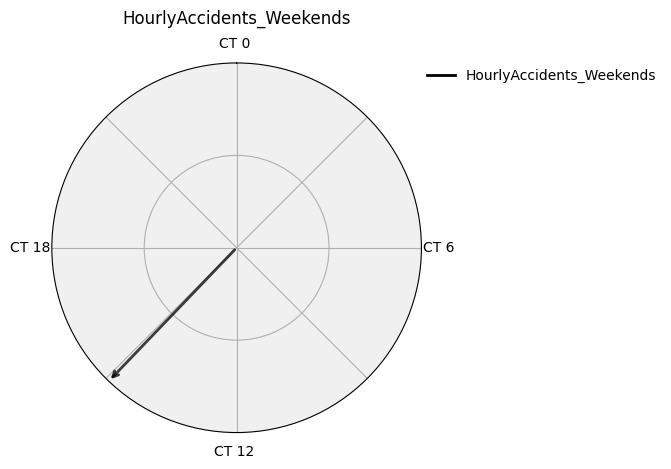

In [17]:
# Izris najboljših modelov
cosinor.plot_df_models(df_workdays, df_best_model_workdays)
cosinor.plot_df_models(df_weekends, df_best_model_weekends)

## RhythmCount

In [12]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_workdays_RC = pd.DataFrame({
    "test": "HourlyAccidents_Workdays",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour_workdays.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour_workdays.values  # Število nesreč za tisto uro
})

df_weekends_RC = pd.DataFrame({
    "test": "HourlyAccidents_Weekends",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour_weekend.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour_weekend.values  # Število nesreč za tisto uro
})



In [13]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

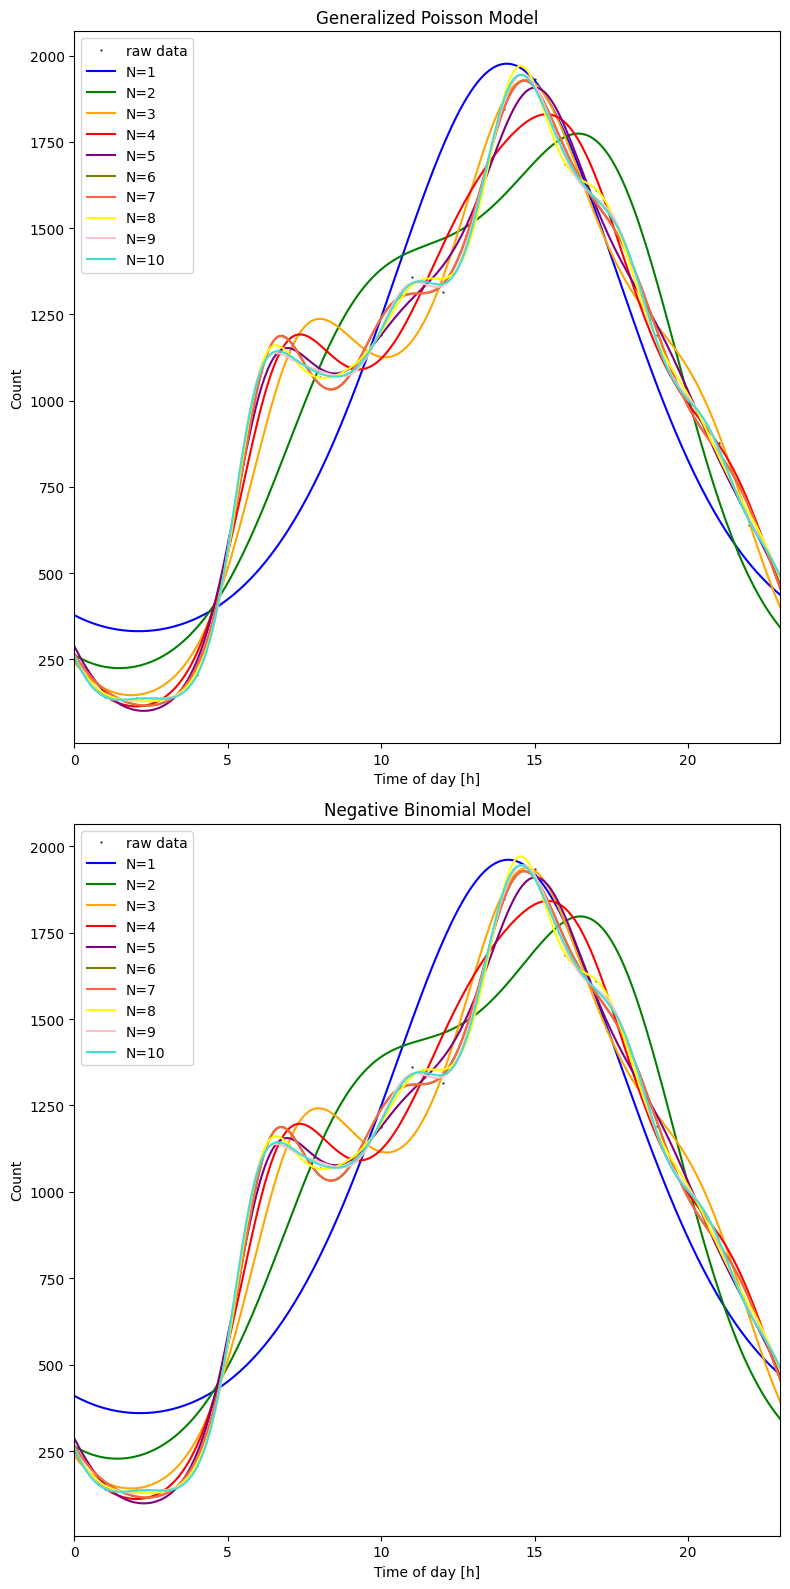

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

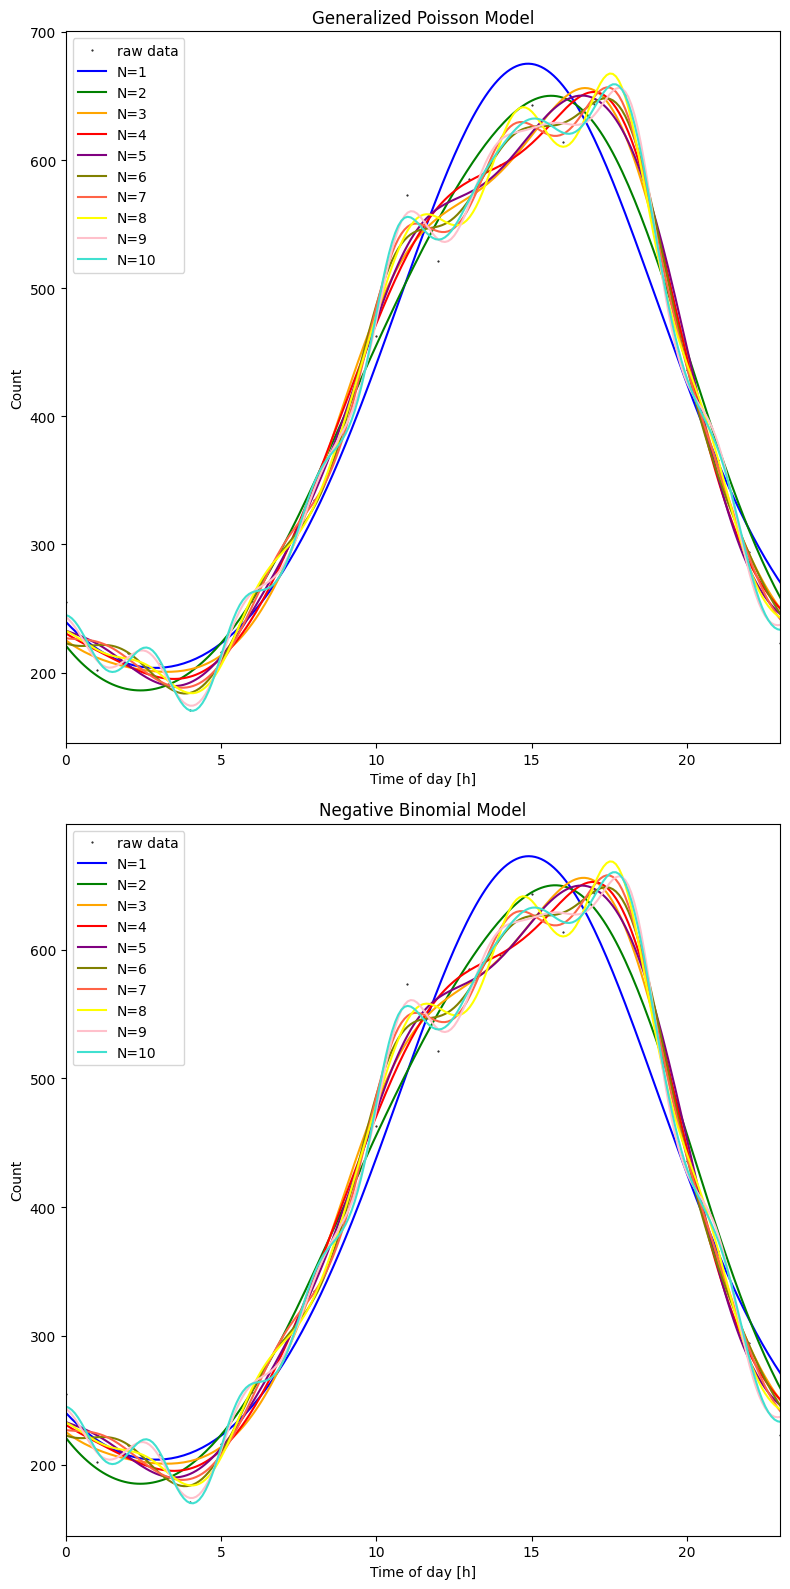

In [14]:
df_results_RC_work = dproc.fit_to_models(df_workdays_RC, count_models, n_components, 24)

df_results_RC_weekend = dproc.fit_to_models(df_weekends_RC, count_models, n_components, 24)

In [15]:
# display(df_results_RC_work)
# display(df_results_RC_weekend)

## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [16]:
# DELOVNIK
best_count_model_work = dproc.get_best_count_model(df_results_RC_work, 'Vuong')
print("Best model: {}".format(best_count_model_work.count_model))
best_model_work = dproc.get_best_n_components(df_results_RC_work, 'Vuong', count_model=best_count_model_work['count_model'])
print("Number of components: {}".format(best_model_work.n_components))

Best model: gen_poisson
Number of components: 6


In [17]:
# VIKEND
best_count_model_weekend = dproc.get_best_count_model(df_results_RC_weekend, 'Vuong')
print("Best model: {}".format(best_count_model_weekend.count_model))
best_model_weekend = dproc.get_best_n_components(df_results_RC_weekend, 'Vuong', count_model=best_count_model_weekend['count_model'])
print("Number of components: {}".format(best_model_weekend.n_components))

Best model: gen_poisson
Number of components: 3


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [18]:
# DELOVNIK
best_n_components_work = dproc.get_best_n_components(df_results_RC_work, 'Vuong')
print("Number of components: {}".format(best_n_components_work.n_components))
best_model_work = dproc.get_best_count_model(df_results_RC_work, 'Vuong', n_components=best_n_components_work['n_components'])
print("Best model: {}".format(best_model_work.count_model))

Number of components: 6
Best model: gen_poisson


In [19]:
# VIKEND
best_n_components_weekend = dproc.get_best_n_components(df_results_RC_weekend, 'Vuong')
print("Number of components: {}".format(best_n_components_weekend.n_components))
best_model_weekend = dproc.get_best_count_model(df_results_RC_weekend, 'Vuong', n_components=best_n_components_weekend['n_components'])
print("Best model: {}".format(best_model_weekend.count_model))

Number of components: 3
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja (delovnik)

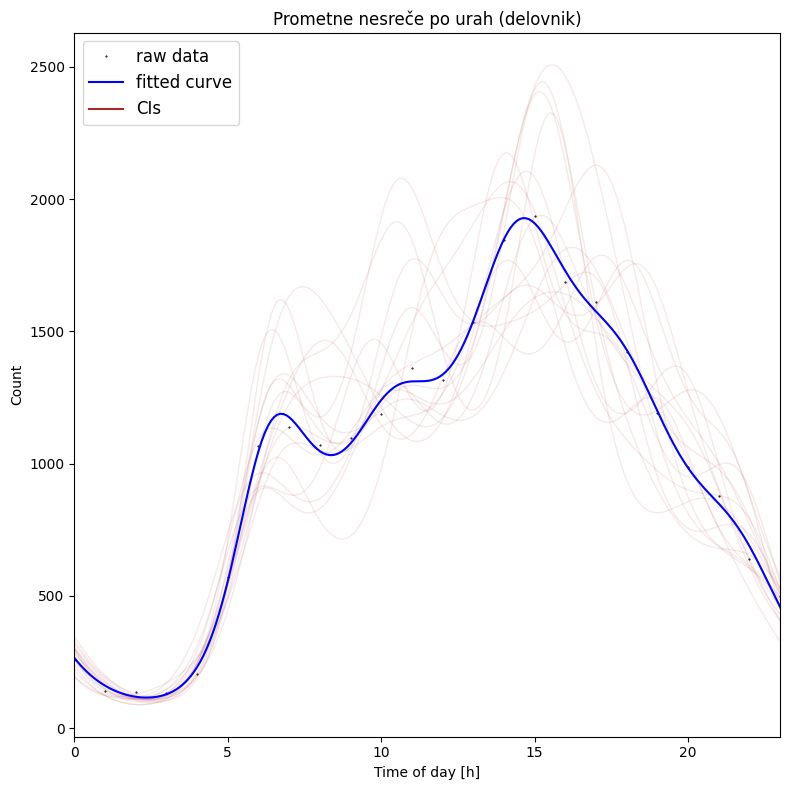

Intervali zaupanja:


,0,1
0,6.588384,6.706768
1,-0.591458,-0.415901
2,-1.011176,-0.851507
3,-0.448249,-0.223330
4,-0.428334,-0.185805
5,-0.379880,-0.235907
6,-0.057093,0.229623
7,-0.147699,0.072075
8,0.014922,0.200875
9,-0.046600,0.134861


In [20]:
# DELOVNIK
count_model_work = best_model_work.count_model
n_components_work = int(best_n_components_work.n_components)

CIs_work = plot.plot_model(df_workdays_RC, count_model_work, n_components_work, title='Prometne nesreče po urah (delovnik)', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs_work)

#### Parametri izbranega modela (delovnik)

In [21]:
CIs_params_work = dproc.calculate_confidence_intervals_parameters(df_workdays_RC, n_components_work, count_model_work, best_model_work['peaks'])
best_model_work = pd.concat([best_model_work, pd.Series(CIs_params_work)], axis=0)
best_model_work=best_model_work[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model_work.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,905.88
mesor,1021.77
peaks,[14.61]
heights,[1927.64]
amplitude_CIs,"[286.39, 1724.58]"
mesor_CIs,"[408.35, 1833.7]"
peaks_CIs,"[14.43, 14.98]"
heights_CIs,"[1828.64, 2090.61]"


### Prikaz najboljšega modela skupaj z intervali zaupanja (vikend)

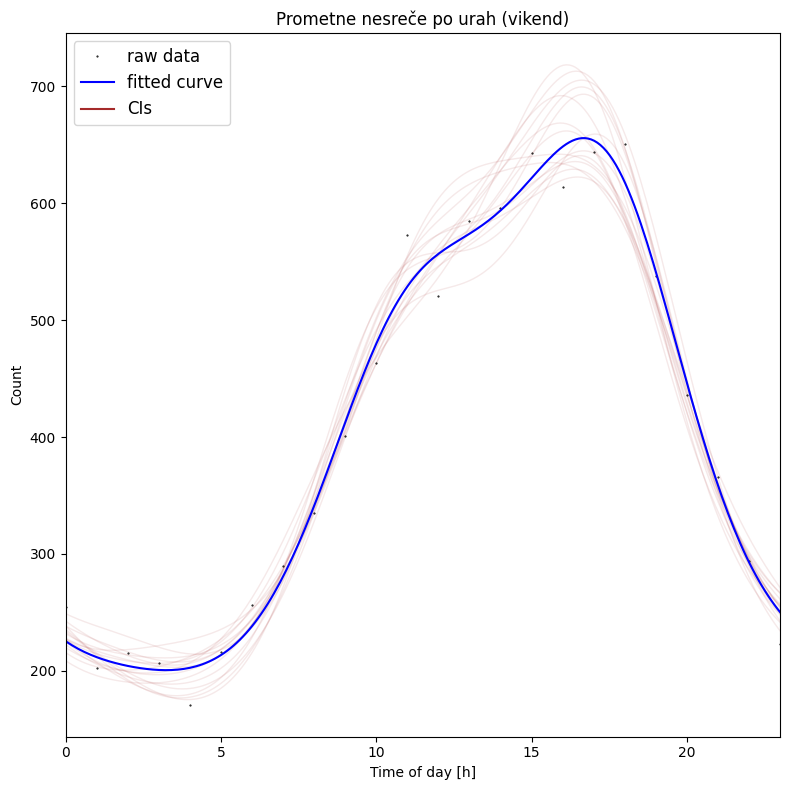

Intervali zaupanja:


,0,1
0,5.883672,5.938386
1,-0.443771,-0.382040
2,-0.485493,-0.418660
3,-0.081895,-0.007200
4,-0.081089,0.005073
5,0.038821,0.091012
6,-0.036504,0.039341
7,-0.233883,0.125164


In [22]:
# VIKEND
count_model_weekend = best_model_weekend.count_model
n_components_weekend = int(best_n_components_weekend.n_components)

CIs_weekend = plot.plot_model(df_weekends_RC, count_model_weekend, n_components_weekend, title='Prometne nesreče po urah (vikend)', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs_weekend)

#### Parametri izbranega modela (vikend)

In [23]:
CIs_params_weekend = dproc.calculate_confidence_intervals_parameters(df_weekends_RC, n_components_weekend, count_model_weekend, best_model_weekend['peaks'])
best_model_weekend = pd.concat([best_model_weekend, pd.Series(CIs_params_weekend)], axis=0)
best_model_weekend=best_model_weekend[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model_weekend.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,3
amplitude,227.81
mesor,428.42
peaks,[16.72]
heights,[656.22]
amplitude_CIs,"[211.37, 244.74]"
mesor_CIs,"[412.14, 443.23]"
peaks_CIs,"[16.2, 17.04]"
heights_CIs,"[627.81, 683.68]"


### Na istem grafu

In [24]:
combined_df = pd.concat([df_workdays_RC, df_weekends_RC], axis=0, ignore_index=True)

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3938: RuntimeWarning: invalid value encountered in log
  (y + a1) * np.log(a2))
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3937: RuntimeWarning: invalid value encountered in log
  a1 * np.log(a1) + y * np.log(mu) -
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3938: RuntimeWarning: invalid value en

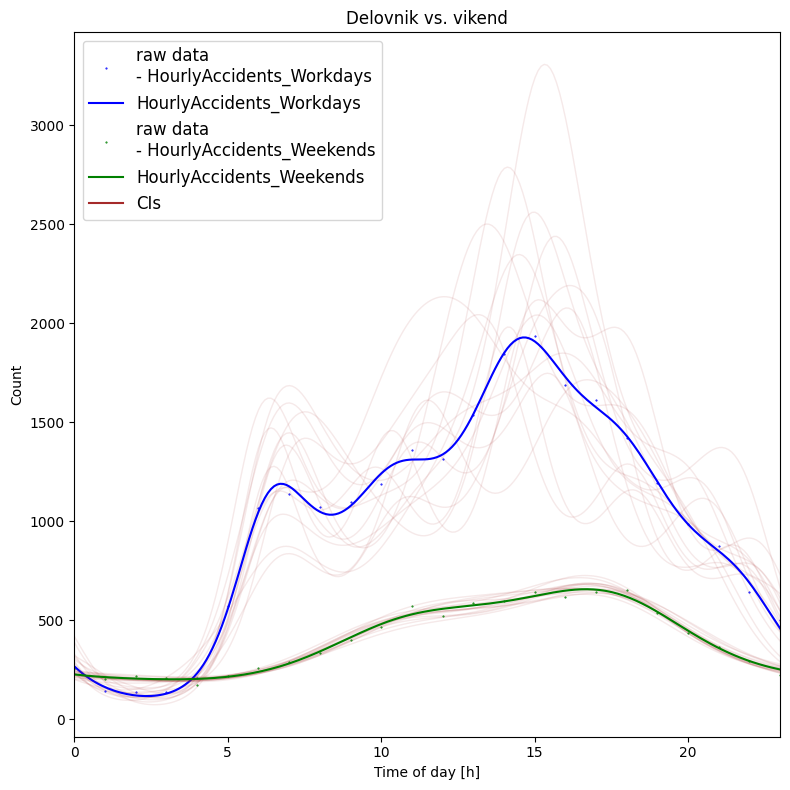

In [25]:
df_results_combined = dproc.compare_by_component(combined_df, 'test', n_components, count_models, ax_indices=[1, 1],
                           ax_titles=['Delovnik vs. vikend'], rows=1, cols=1)

In [26]:
display(df_results_combined)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,...,Y(est),X_test,Y_test,test,amplitude_CIs,mesor_CIs,peaks_CIs,heights_CIs,CIs_model_params_0,CIs_model_params_1
0,gen_poisson,6,905.90,1021.76,[14.61],[1927.67],3.774793e-26,18474.231407,257.057296,273.550049,...,"[265.7309088495375, 160.88441528575908, 118.92...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[265.7309088495375, 251.49592437489022, 238.18...",HourlyAccidents_Workdays,"[836.02, 1018.29]","[960.62, 1138.47]","[13.81, 15.49]","[1803.67, 2145.44]","{0: 6.565424530836237, 1: -0.6447082274942009,...","{0: 6.715659665466429, 1: -0.3383324102281131,..."
1,gen_poisson,3,227.56,428.15,[16.72],[655.71],3.250337e-19,10089.638059,228.699441,238.123871,...,"[225.33925718878766, 211.68195470644906, 204.1...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[225.33925718878766, 223.56630573792336, 221.8...",HourlyAccidents_Weekends,"[211.0, 243.03]","[412.45, 446.32]","[16.3, 17.05]","[629.92, 682.88]","{0: 5.879606188755264, 1: -0.4420130070150905,...","{0: 5.939082171699403, 1: -0.3958917112225625,..."
